In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import plotly.express as px



warnings.simplefilter(action='ignore')
tqdm.pandas()
plt.style.use('ggplot')
pd.set_option('use_inf_as_na', True)
plt.rcParams['figure.figsize'] = (15,6)

In [8]:
import yfinance as yf

In [9]:
df2 = yf.download('TSLA','2021-01-01')

[*********************100%***********************]  1 of 1 completed


In [10]:
df = yf.download('AAPL','2021-01-01')

[*********************100%***********************]  1 of 1 completed


In [11]:
df['hl_diff'] = df['High'] - df['Low']
df['oc_diff'] = df['Open'] - df['Close']

In [12]:
df2['hl_diff'] = df2['High'] - df2['Low']
df2['oc_diff'] = df2['Open'] - df2['Close']

In [13]:
df.corr()
#volume - min max rate corr
#hl diff --> relate with high

,Open,High,Low,Close,Adj Close,Volume,hl_diff,oc_diff
Open,1.000000,0.997467,0.996447,0.992657,0.992637,-0.022679,0.294117,0.021070
High,0.997467,1.000000,0.996168,0.996415,0.996325,0.003182,0.325240,-0.030824
Low,0.996447,0.996168,1.000000,0.996275,0.996368,-0.063045,0.241287,-0.038058
Close,0.992657,0.996415,0.996275,1.000000,0.999952,-0.034448,0.284303,-0.100023
Adj Close,0.992637,0.996325,0.996368,0.999952,1.000000,-0.036752,0.282306,-0.099789
Volume,-0.022679,0.003182,-0.063045,-0.034448,-0.036752,1.000000,0.716945,0.098173
hl_diff,0.294117,0.325240,0.241287,0.284303,0.282306,0.716945,1.000000,0.069459
oc_diff,0.021070,-0.030824,-0.038058,-0.100023,-0.099789,0.098173,0.069459,1.000000


In [14]:
df2.corr()
#volume - min max rate corr
#hl diff --> relate with high

,Open,High,Low,Close,Adj Close,Volume,hl_diff,oc_diff
Open,1.000000,0.996265,0.993727,0.988319,0.988319,0.003735,0.553957,0.086219
High,0.996265,1.000000,0.993887,0.994629,0.994629,0.040519,0.582290,0.020517
Low,0.993727,0.993887,1.000000,0.995139,0.995139,-0.040937,0.488980,0.000569
Close,0.988319,0.994629,0.995139,1.000000,1.000000,0.006982,0.530636,-0.066618
Adj Close,0.988319,0.994629,0.995139,1.000000,1.000000,0.006982,0.530636,-0.066618
Volume,0.003735,0.040519,-0.040937,0.006982,0.006982,1.000000,0.621622,-0.021189
hl_diff,0.553957,0.582290,0.488980,0.530636,0.530636,0.621622,1.000000,0.157919
oc_diff,0.086219,0.020517,0.000569,-0.066618,-0.066618,-0.021189,0.157919,1.000000


### Функции

### Rolling

In [15]:
def get_rolling_data(df,ma_periods=[(7,'D'),(14,'D')]):
    '''
    Функция подсчета средних значений по временному ряду на последний момент времени в датафрейме

    df - dataframe с какими то значениями, пока что имеется в виду только один временной ряд (pd.Series)  
    
    ma_periods - MovingAverage лист тюплов вида ("Период усреднения","Таймстемп усреднения")  
    
    '''
    ma_list = {}
    
    for params in ma_periods:
        ma_list[str(params[0])+params[1]] = df.resample(params[1]).mean().rolling(params[0],1).mean().iloc[-1]
    return ma_list

In [16]:
set(map(lambda x: x>100,get_rolling_data(df['Open']).values()))=={True}

True

<AxesSubplot:xlabel='Date'>

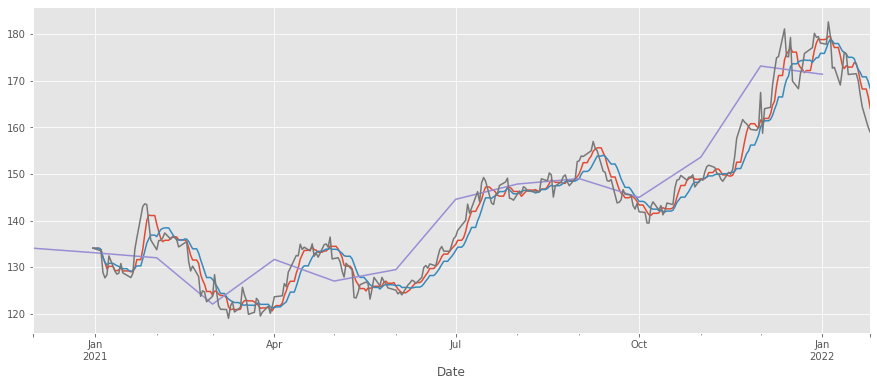

In [17]:
for params in [(7,'D'),(14,'D'),(1,'M')]:
        df['Open'].resample(params[1]).mean().rolling(params[0],1).mean().plot()
df['Open'].plot()

### Sharpness

In [18]:
def is_sharp(df):
    '''
    Функция проверки резкости падения

    Eсли изменения в % значения t от t-1 отличается более чем на 3 стандартных отклонения, то говорим что тут какой то пиздец  
    
    df - pd.Series объект, где индект это datetime , а значения это наш показатель (цена)
    
    '''
    return df.diff().iloc[-1]  <=  df.diff().mean() - df.diff().std()*3

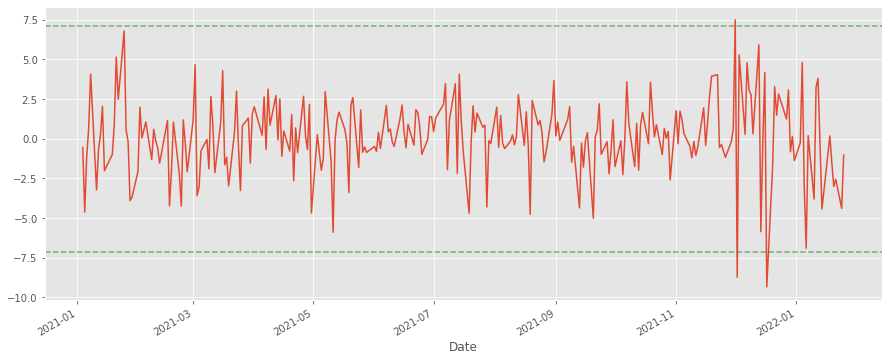

In [19]:
df['Open'].diff().plot()
plt.axhline(df['Open'].diff().std()*3,linestyle='--',alpha=.5,color='g')
plt.axhline(df['Open'].diff().std()*-3,linestyle='--',alpha=.5,color='g')

In [20]:
is_sharp(df['Open'])

False

In [33]:
(1-0.1) * (1-0.2)

0.7200000000000001

### Class

In [46]:
class MarketWorker():
    def __init__(self,name='Karlos',fee_rate=0.0024,profit_rate=0.01,money_limit=100,risk_margine = 0,ma_periods=[(45,'D'),(14,'D'),(7,'D')]):
        self.name = name
        self.sell_fee_rate = fee_rate
        self.profit_rate = profit_rate
        self.buy_price = None
        self.n_deals = 0
        self.profit = 0
        self.price = None
        self.log = {}
        self.passive = money_limit
        self.active = None
        self.risk_margine = risk_margine
        self.ttl_profit = 0
        self.ma_periods = ma_periods

    def check_rolling(self):

        self.rolling_values = get_rolling_data(self.df)
        return set(
                    map(lambda x: x > self.price * (1-self.profit_rate) * (1-self.risk_margine),
                        self.rolling_values.values())
                    )=={True}


    def check_sharpness(self):
        is_sharp(self.df)
    

    def check_buy_shit(self):

        if self.check_rolling():
            self.buy_shit()
    

    def check_sell_shit(self):
        if (self.price / self.buy_price -1) > (self.profit_rate + self.sell_fee_rate):
            self.sell_shit()
    




    def buy_shit(self):
        self.buy_price = self.price
        self.active = self.passive
        self.passive = 0
        # print(f'{self.df.index[-1]} buy price :{self.buy_price}')




    def sell_shit(self):
        self.profit = self.active * (self.price / self.buy_price ) *(1-self.sell_fee_rate)
        self.n_deals+=1
        self.ttl_profit+=self.profit
        self.passive += self.profit
        self.active = 0
        # print(f'{self.df.index[-1]} sell price :{self.price}')

    def scan(self,data):

        self.df = data

        self.price = self.df.iloc[-1]
        
        if self.passive>0:
            self.check_buy_shit()
        else:
            self.check_sell_shit()

        self.log[self.df.index[-1]] = {
                                        'buy_price':self.buy_price,
                                        'profit':self.profit ,
                                        'ttl_profit':self.ttl_profit ,
                                        'n_deals':self.n_deals,
                                        'current_price':self.price,
                                        'passive':self.passive,
                                        'active':self.active,
                                        'checkpoints':self.rolling_values}
        

In [47]:
agent = MarketWorker()
agent_2 = MarketWorker(profit_rate=.1)
agent_3 = MarketWorker(risk_margine=.02,profit_rate=.1)

In [48]:
start = np.random.randint(0,90)
end = np.random.randint(90,150)
for i in range(90):
    agent.scan(df2['Open'].iloc[start:-end+i])
    agent_2.scan(df2['Open'].iloc[start:-end+i])
    agent_3.scan(df2['Open'].iloc[start:-end+i])

profit : 1169.251736540008


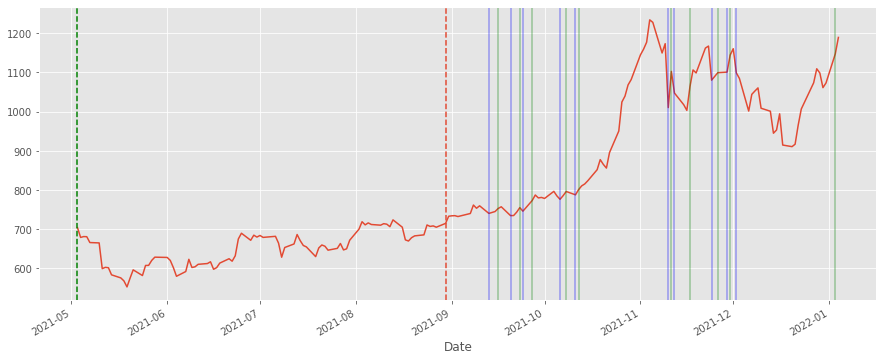

In [49]:
agent.df.plot()
plt.axvline(df['Open'].index[-end],linestyle='--')
plt.axvline(df['Open'].index[start],linestyle='--',color='g')
[plt.axvline(x,color='g',alpha=.35) for x in pd.DataFrame(agent.log).T['n_deals'].diff().where(lambda x: x==1).dropna().index]
[plt.axvline(x,color='b',alpha=.35) for x in pd.DataFrame(agent.log).T['active'].fillna(0).diff().where(lambda x: x>0).dropna().index]
print(f'profit : {agent.ttl_profit}')


profit : 384.1645758770893


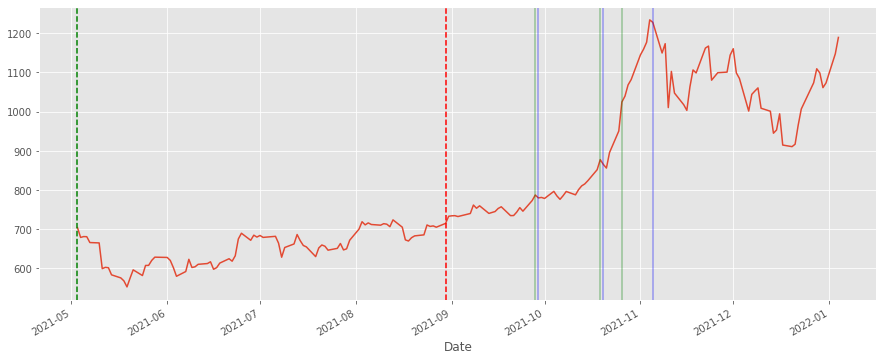

In [50]:
agent_2.df.plot()
plt.axvline(df['Open'].index[-end],linestyle='--',color='r')
plt.axvline(df['Open'].index[start],linestyle='--',color='g')
[plt.axvline(x,color='g',alpha=.35) for x in pd.DataFrame(agent_2.log).T['n_deals'].diff().where(lambda x: x==1).dropna().index]
[plt.axvline(x,color='b',alpha=.35) for x in pd.DataFrame(agent_2.log).T['active'].fillna(0).diff().where(lambda x: x>0).dropna().index]
print(f'profit : {agent_2.ttl_profit}')


profit : 384.1645758770893


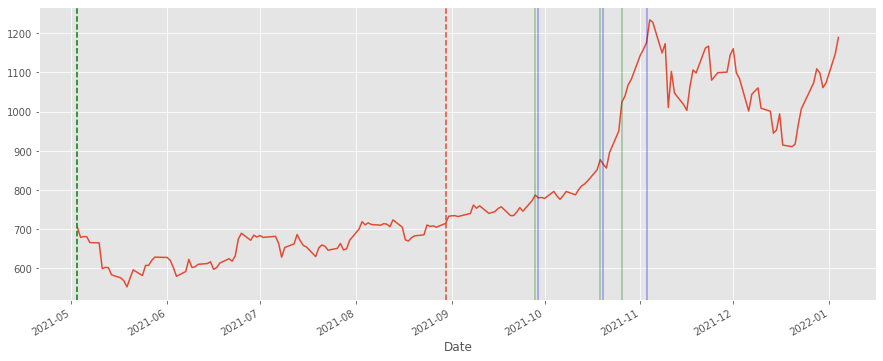

In [51]:
agent_3.df.plot()
plt.axvline(df['Open'].index[-end],linestyle='--')
plt.axvline(df['Open'].index[start],linestyle='--',color='g')
[plt.axvline(x,color='g',alpha=.35) for x in pd.DataFrame(agent_3.log).T['n_deals'].diff().where(lambda x: x==1).dropna().index]
[plt.axvline(x,color='b',alpha=.35) for x in pd.DataFrame(agent_3.log).T['active'].fillna(0).diff().where(lambda x: x>0).dropna().index]
print(f'profit : {agent_3.ttl_profit}')


In [53]:
tt = []
for _ in tqdm(range(20)):
    grid_space = pd.DataFrame()
    start = np.random.randint(0,90)
    end = np.random.randint(90,150)
    for risk in np.arange(0,0.05,0.01):
        for profit in np.arange(0.01,.21,.01):
            agent = MarketWorker(risk_margine=risk,profit_rate=profit)
            for i in range(90):  
                agent.scan(df2['Open'].iloc[start:-end+i])
            grid_space.loc[risk,profit] = agent.ttl_profit
    tt.append({'profit':grid_space.max(axis=0).idxmax(),'risk':grid_space.max(axis=1).idxmax(),'ttl_gain_90_days':grid_space.max(axis=0).max()})

100%|██████████| 20/20 [00:40<00:00,  2.05s/it]


In [54]:
px.imshow(grid_space)